In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm


from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LassoCV
from catboost import CatBoostClassifier


# import shap
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report, roc_curve


# Описание задания 


In [2]:
# closed_creds - количество закрытых кредитов
# active_cred_sum_overdue - суммарная задолженность по активным кредитам
# active_cred_sum - сумма всех активных кредитов
# active_cred_day_overdue - суммарная просрочка в днях по всем активным кредитам
# active_cred_max_overdue - максимальная сумма просроченной задолженности по активным кредитам

# Переменные характеризующие клиента
# age - возраст
# gender - пол
# region - регион
# month_income - ежемесячный доход

# Переменные, характеризующие кредит, по которому нужно сделать прогноз
# first_loan - сумма, которую клиент хочет получить в кредит (из заявки)
# first_days_quant - срок, на которую клиент хочет взять кредит
# loan_cost_all - одобренная клиенту сумма кредита
# order_date - дата подачи заявки на получение кредита
# cost_all - сумма всех выплат по одобренному кредиту
# order_id - id заявки
# client_id - id клиента

# Целевая переменная:
# expert - решение, которое принято по заявке (0 - одобрено, 1 - отклонено)

# Выполнение

In [3]:
data = pd.read_csv('./data.csv', sep=';')
#сюда вставить файл с тестовым заданием соответственно 

In [4]:
data.head(15)

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
0,143822.00,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,2017-07-23,0.0,728319,320464,1
1,0.00,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,2017-07-23,0.0,728321,320466,1
2,51356.00,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,2017-07-23,0.0,728323,320467,1
3,0.00,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,2017-07-23,0.0,728447,320533,1
4,12298.00,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,2017-07-23,0.0,728421,298598,1
5,786916.00,11,0.00,1063763.00,0,10395.39,47,0,38,10000.0,5500,14,50000.0,2017-07-23,0.0,728526,320564,0
6,786916.00,11,0.00,1063763.00,0,10395.39,47,0,38,10000.0,5500,14,50000.0,2017-07-23,0.0,728526,320564,0
7,786916.00,11,0.00,1063763.00,0,10395.39,47,0,38,10000.0,5500,14,50000.0,2017-07-23,0.0,728526,320564,0
8,786916.00,11,0.00,1063763.00,0,10395.39,47,0,38,10000.0,5500,14,50000.0,2017-07-23,0.0,728526,320564,0
9,0.00,0,21143.00,21143.00,1016,10924.00,28,1,0,10000.0,10000,90,0.0,2017-07-23,0.0,728454,123851,1


In [5]:
data.shape #кол-во строк 

(50001, 18)

In [6]:
#Обратим внимание на два обобщающих признака id заявки и id клиента 
#Узнаем кол-во уникальных заявок  
#оно равно 42857, значит одна заявка может редактироваться и включать в себя разные данные или это бесполезные дубликаты - появился резон проверить на повторяющиеся строки 
data.order_id.nunique() #- кол-во уникальных заявок  

42857

In [7]:
#быть может дубликаты были сделаны изначально, чтобы убрать дисбаланс классов, сравним баланс лейблов до и после удаления повторяющихся строк 

In [8]:
#баланс не изменился, даже стало немного лучше. Вывод: убираем дупликаты 
pd.DataFrame({'standart_balance': data['expert'].value_counts(), 'bal_after_drop_dup': data.drop_duplicates()['expert'].value_counts()})

,standart_balance,bal_after_drop_dup
1,37464,31714
0,12537,11229


In [9]:
data = data.drop_duplicates() #убираем дупликаты

In [10]:
data.shape #новая размерность данных

(42943, 18)

In [11]:
X = data.copy()

In [12]:
#Рассмотрим данные на наличие пропусков и и их типы
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42943 entries, 0 to 50000
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   closed_cred_sum          42943 non-null  float64
 1   closed_creds             42943 non-null  int64  
 2   active_cred_sum_overdue  42943 non-null  float64
 3   active_cred_sum          42943 non-null  float64
 4   active_cred_day_overdue  42943 non-null  int64  
 5   active_cred_max_overdue  42943 non-null  float64
 6   age                      42943 non-null  int64  
 7   gender                   42943 non-null  int64  
 8   region                   42943 non-null  int64  
 9   first_loan               42926 non-null  float64
 10  loan_cost_all            42943 non-null  int64  
 11  first_days_quant         42943 non-null  int64  
 12  month_income             42943 non-null  float64
 13  order_date               42943 non-null  object 
 14  cost_all              

In [13]:
X.isna().mean()

closed_cred_sum            0.000000
closed_creds               0.000000
active_cred_sum_overdue    0.000000
active_cred_sum            0.000000
active_cred_day_overdue    0.000000
active_cred_max_overdue    0.000000
age                        0.000000
gender                     0.000000
region                     0.000000
first_loan                 0.000396
loan_cost_all              0.000000
first_days_quant           0.000000
month_income               0.000000
order_date                 0.000000
cost_all                   0.000000
order_id                   0.000000
client_id                  0.000000
expert                     0.000000
dtype: float64

In [14]:
#В отношении пропусков данные достаточно чистые, есть пропуски только в графе first_loan 
#Данные пропуски можно заменить либо на медианные, либо на модальные значения, Но можно обратить внимание, что данные 
#столбца first_loan кажутся идентичными с данными столбца loan_cost_all, но заменять их всё равно на них нельзя потому что loan_cost_all это данные уже
# одобренного кредита 

In [15]:
X.query('first_loan == loan_cost_all').shape[0], round((X.query('first_loan == loan_cost_all').shape[0]/X.shape[0]*100), 2)

(35070, 81.67)

In [16]:
#35070 или 82% строк имеют равные значения в данных столбцах
# Можно сделать вывод, что организация первоначально одабряет 82% заявок на ту же сумму которая была зпрошена 

In [17]:
#Замечено два признака, которые можно считать утечками данных 
# 1. loan_cost_all - одобренная клиенту сумма кредита - эти данные появяются уже после общего итога об одобрении 
# 2. cost_all - сумма выплат по одобренноу кредиту 
# удалим их сразу

In [18]:
X = X.drop(['loan_cost_all', 'cost_all'], axis=1)

In [19]:
#Замена пустых значений на модальные 
values = {"first_loan": int(X.first_loan.mode())}
# df.fillna(value=values)
X = X.fillna(value=values) 

In [20]:
X.first_loan

0        10000.0
1        10000.0
2        10000.0
3        10000.0
4         5000.0
          ...   
49995     3000.0
49996     4000.0
49997     2000.0
49998    10000.0
50000     2000.0
Name: first_loan, Length: 42943, dtype: float64

In [21]:
X.first_loan

0        10000.0
1        10000.0
2        10000.0
3        10000.0
4         5000.0
          ...   
49995     3000.0
49996     4000.0
49997     2000.0
49998    10000.0
50000     2000.0
Name: first_loan, Length: 42943, dtype: float64

In [22]:
# Достаточно странно, что есть заявки с нулевой суммой кредита, эти данные можно либо удалить, либо добавить моадльные значения, либо оставить всё как есть 
# Пока оставим 
X.query('first_loan == 0')[['expert']].value_counts()

Series([], dtype: int64)

In [23]:
#Продолжим смотреть на призаки с id, проверим уникальность комбинации id заявки и id клиента:
# Случай А. если число уникальных комбинаций будет равно числу строк, это будет означать, что для каждого человека 
# есть одна уникальная заявка, но по идее так не должно быть, потому что: 
# Случай Б. один клиент может делать несколько заявок или одну заявку оформляют сразу несколько клиентов с разными id  


In [24]:
id_data = X[['order_id', 'client_id']].astype(str)
id_data['sum_od_order_and_client'] = id_data.order_id + id_data.client_id
id_data.sum_od_order_and_client.nunique() # - Случай Б, как и ожидалось 

42857

In [25]:
#Проверим включает в себя id клиента несколько id заявок или наоборот, или и то и другое:

id_data2 = X[['order_id', 'client_id']]
countof_Ord_for_One_Client = id_data2.groupby('client_id').agg({'order_id': 'count'}).sort_values(by='order_id', ascending=False).value_counts() #подтверждение что у одного клиента может быть больше чем одна заявка

countof_Client_for_One_Ord = id_data2.groupby('order_id').agg({'client_id': 'count'}).sort_values(by='client_id', ascending=False).value_counts() #подтверждение что в одной заявке может участвовать больше одного клиента, в данном случае Максимум 2 клиента в 86 заявках 
countof_Ord_for_One_Client, countof_Client_for_One_Ord
# # 42943

(order_id
 1           37656
 2            2268
 3             204
 4              21
 5               7
 6               2
 8               1
 dtype: int64,
 client_id
 1            42771
 2               86
 dtype: int64)

In [26]:
# # Из вышеизложенного варианты новых признаков:
# 1. Общее кол-во заявок у данного клиента 'count_of_order'  
# 2. Сколько клиентов участвуют в одной заявке 'count_of_clients_in_order'
# 3. Величина суммарного дохода клиентов участвующих в заявке 'sum_salary_of_members'

In [27]:
#вспомогательная таблица в которой будет написано id клиента и кол-во его заявок  
countof_Ord_for_One_Client2 = id_data2.groupby('client_id', as_index=False)\
                                      .agg({'order_id': 'count'})\
                                      .rename(columns={'order_id' : 'count_of_order'})
countof_Ord_for_One_Client2.head(5)

,client_id,count_of_order
0,109,1
1,144,1
2,220,2
3,291,1
4,324,2


In [28]:
#вспомогательная таблица в которой будет написано id заявки и кол-во клиентов участвующих в заявке 
countof_Client_for_One_Ord2 = id_data2.groupby('order_id', as_index=False)\
                                      .agg({'client_id': 'count'})\
                                      .rename(columns={'client_id' : 'count_of_clients_in_order'})
countof_Client_for_One_Ord2.head(5)                                      

,order_id,count_of_clients_in_order
0,695828,1
1,695829,1
2,695830,1
3,695831,1
4,695832,1


In [29]:
#вспомогательная таблица в которой будет указано id сделки и суммарная зарплата членов сделки 
id_data3 = X[['order_id', 'client_id', 'month_income']]
Sum_salary = id_data3.groupby('order_id', as_index=False)\
                     .agg({'client_id': 'count', 'month_income': 'sum'})\
                     .rename(columns={'month_income' : 'sum_salary_of_members'})\
                     .drop('client_id', axis=1)
Sum_salary.head(5)

,order_id,sum_salary_of_members
0,695828,50000.0
1,695829,50000.0
2,695830,35000.0
3,695831,35000.0
4,695832,50000.0


In [30]:
#Добавим получившиеся столбцы в таблицу признаков 
#добавим в X признак кол-ва сделок на клиента по id клиента
X = X.merge(countof_Ord_for_One_Client2) 

#добавим в X признак кол-ва клиентов, участвующих в одной сделке 
X = X.merge(countof_Client_for_One_Ord2) 

#добавим в X признак общая сумма зп за месяц всех клиентов участвующих в сделке 
X = X.merge(Sum_salary) 

In [31]:
X

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,first_days_quant,month_income,order_date,order_id,client_id,expert,count_of_order,count_of_clients_in_order,sum_salary_of_members
0,143822.00,22,104.12,130068.80,8,756.09,31,0,36,10000.0,196,0.0,2017-07-23,728319,320464,1,1,1,0.0
1,0.00,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,17,20000.0,2017-07-23,728321,320466,1,1,1,20000.0
2,51356.00,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,84,0.0,2017-07-23,728323,320467,1,1,1,0.0
3,0.00,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,7,0.0,2017-07-23,728447,320533,1,2,1,0.0
4,0.00,0,22784.19,32103.52,934,22784.19,29,0,0,10000.0,20,0.0,2017-08-13,759194,320533,1,2,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42938,0.00,0,26758.57,25000.00,371,26758.57,44,1,42,3000.0,23,50000.0,2017-08-13,759462,338231,0,1,1,50000.0
42939,0.00,0,74662.61,79662.61,2593,42204.55,27,1,0,4000.0,20,0.0,2017-08-13,759472,96091,1,1,1,0.0
42940,21653.49,2,0.00,0.00,0,0.00,28,0,75,2000.0,10,20000.0,2017-08-13,759475,338240,1,1,1,20000.0
42941,0.00,0,0.00,1000.00,0,941.00,22,0,0,10000.0,20,35000.0,2017-08-13,759485,338246,1,1,1,35000.0


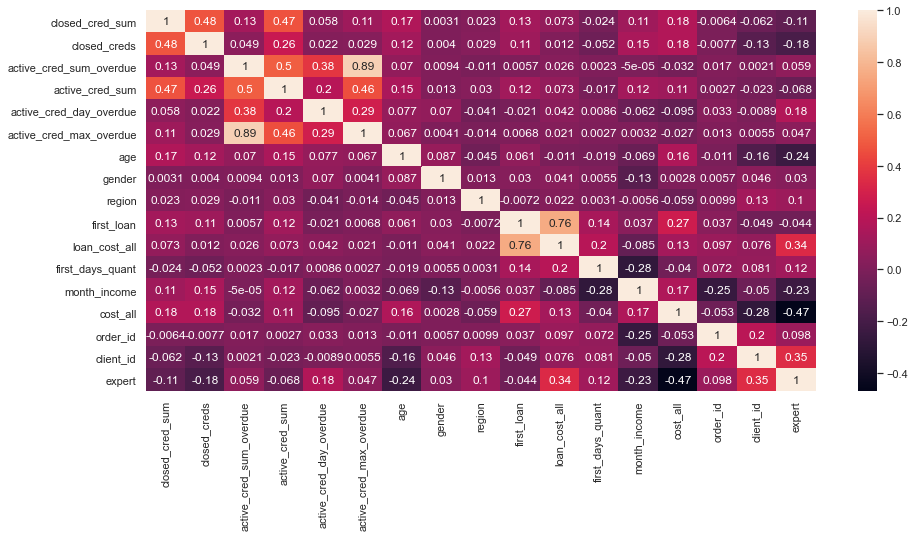

In [32]:
#Для начала посмотрим на матрицу корреляций числовых признаков для того, чтобы оценить расклад фич
sns.set(rc={'figure.figsize':(15, 7)}) 
sns.heatmap(data.corr(),annot = True);
#результирующий лейбл умеренно коррелирует (>0.3) только с loan_cost_all и с cliend_id

#высокая взаимосвязь (от 0.7 до 0.9) у признаков:
# а. active_cred_sum_overdue и active_cred_max_overdue что достаточно логично ибо из суммарной задолженности по активным кредитам формируется максимальная задолженность по активным кредитам 
# б. loan_cost_all и first_loan также закономерная зависимость ибо первая вытекает из второй 

In [33]:
#Приступим к анализу блока переменных, характеризующих кредитную историю клиента 
# 1. closed_cred_sum - сумма которую клиент выплатил по ранее взятым закрытым кредитам 

<AxesSubplot:>

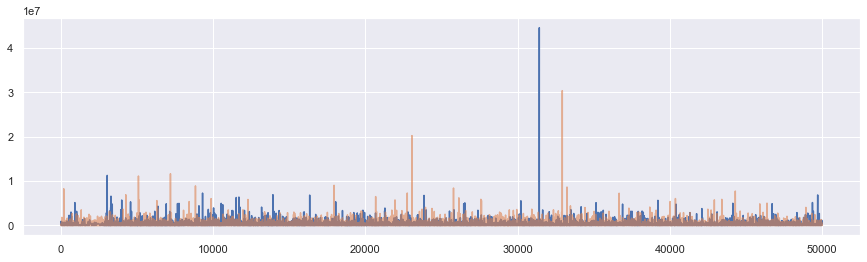

In [34]:
#посмотрим на распределение данных для тех заявок, что одобрены и не одобрены 
sns.set(rc={'figure.figsize':(15, 4)}) 
data.query('expert == 0').closed_cred_sum.plot()
data.query('expert == 1').closed_cred_sum.plot(alpha=0.6)
#зависимость из визуального анализа не заметна 

In [35]:
 pd.DataFrame({'-': data.query('expert == 1').closed_cred_sum.describe().apply(lambda x: format(x, 'f')), 
               '+': data.query('expert == 0').closed_cred_sum.describe().apply(lambda x: format(x, 'f'))})

,-,+
count,31714.000000,11229.000000
mean,147921.350909,270471.228700
std,432906.117297,674371.515208
min,0.000000,0.000000
25%,2000.000000,20714.000000
50%,28999.000000,92800.000000
75%,124796.500000,288649.170000
max,30390879.000000,44574209.380000


In [36]:
#так как значения квантилей для отклоненных и одобренных значительно отличаются, разобьём значениям согласно квантилям для одобренных значений    

In [37]:
pd.DataFrame(pd.qcut(X['closed_cred_sum'],4)).closed_cred_sum.unique()

[(39835.0, 165000.0], (-0.001, 5000.0], (5000.0, 39835.0], (165000.0, 44574209.38]]
Categories (4, interval[float64]): [(-0.001, 5000.0] < (5000.0, 39835.0] < (39835.0, 165000.0] < (165000.0, 44574209.38]]

In [38]:
X['closed_cred_sum_Category'] = pd.cut(X['closed_cred_sum'], bins=[0, 5000, 40000, 165000, 45000000], include_lowest=True, labels=['1','2','3','4']).astype(int);

In [39]:
#Кол-во значений в каждой из получившихся категорий
X.closed_cred_sum_Category.value_counts()

1    10935
4    10728
2    10640
3    10640
Name: closed_cred_sum_Category, dtype: int64

In [40]:
# 2. closed_creds - количество закрытых кредитов

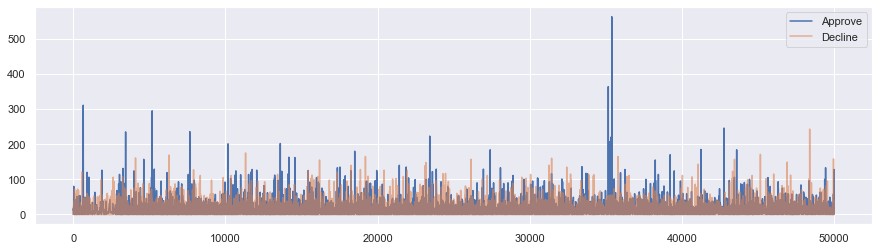

In [41]:
sns.set(rc={'figure.figsize':(15, 4)}) 
data.query('expert == 0').closed_creds.plot(label='Approve')
data.query('expert == 1').closed_creds.plot(alpha=0.6, label='Decline')
plt.legend()


<AxesSubplot:xlabel='expert', ylabel='closed_creds'>

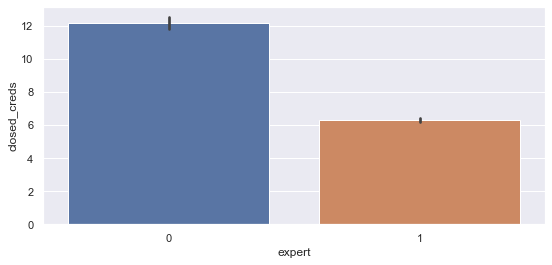

In [42]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.barplot(x='expert', y='closed_creds', data=data)

In [43]:
#из визуального анализа данного признака заметно зависимость, что чем больше кол-во закрытых кредитов, там больше у тебя будет одобренных заявок 

In [44]:
 pd.DataFrame({'-': data.query('expert == 1').closed_creds.describe().apply(lambda x: format(x, 'f')), 
               '+': data.query('expert == 0').closed_creds.describe().apply(lambda x: format(x, 'f'))})

,-,+
count,31714.000000,11229.000000
mean,6.299268,12.178645
std,11.426447,18.783552
min,0.000000,0.000000
25%,1.000000,2.000000
50%,3.000000,7.000000
75%,7.000000,15.000000
max,243.000000,563.000000


In [45]:
#у 50% одобренных заявок кол-во кредитов не превышает 7 штук, сделаем бинарный признак по моде + столбца, если > 7= 1, <7 =0

In [46]:
X['binary_closed_creds'] = X['closed_creds'].apply(lambda x: 1 if x>7 else 0)

In [47]:
# 3. active_cred_sum_overdue - суммарная задолженность по активным кредитам
#Данным признак обязан быть показательным и хорошо разделять выборку, ибо на текущую задолженность точно необходимо смотреть при выдаче кредита 

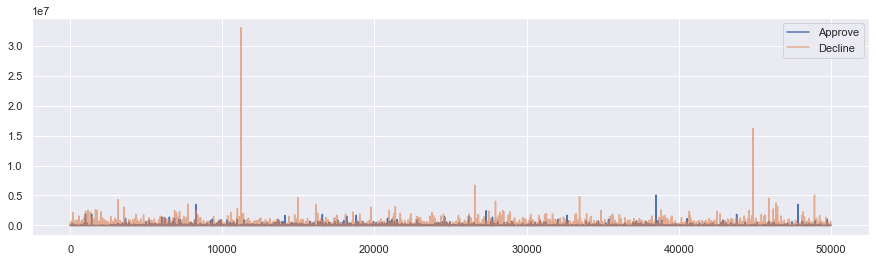

In [48]:
sns.set(rc={'figure.figsize':(15, 4)}) 
data.query('expert == 0').active_cred_sum_overdue.plot(label='Approve')
data.query('expert == 1').active_cred_sum_overdue.plot(alpha=0.6, label='Decline')
plt.legend()

<AxesSubplot:xlabel='expert', ylabel='active_cred_sum_overdue'>

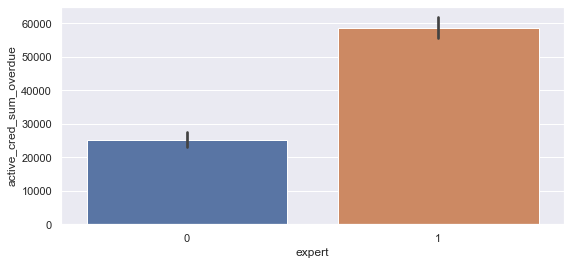

In [49]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.barplot(x='expert', y='active_cred_sum_overdue', data=data)

In [50]:
#Визуальный анализ: предоположение о том, что чем больше текущая задолженность, тем меньше вероятность получить новый кредит абсолютно верна 

In [51]:
 pd.DataFrame({'-': data.query('expert == 1').active_cred_sum_overdue.describe().apply(lambda x: format(x, 'f')), 
               '+': data.query('expert == 0').active_cred_sum_overdue.describe().apply(lambda x: format(x, 'f'))})

,-,+
count,31714.000000,11229.000000
mean,58538.416364,25068.085877
std,277812.601061,122387.125711
min,0.000000,0.000000
25%,0.000000,0.000000
50%,9000.000000,0.000000
75%,39399.817500,6694.250000
max,33030999.240000,5068666.760000


In [52]:
#Можно легко создать бинарный признак, который разделит выборку на тех у кого задолженность больше 0 и меньше. Так как c 50% вероятностью у клиента одобрят кредит, если его просроченная сумма активных кредитов =
X['Binary_active_cred_sum_overdue'] = X['active_cred_sum_overdue'].apply(lambda x: 1 if x>0 else 0)

In [53]:
#4. active_cred_sum - сумма всех активных кредитов 

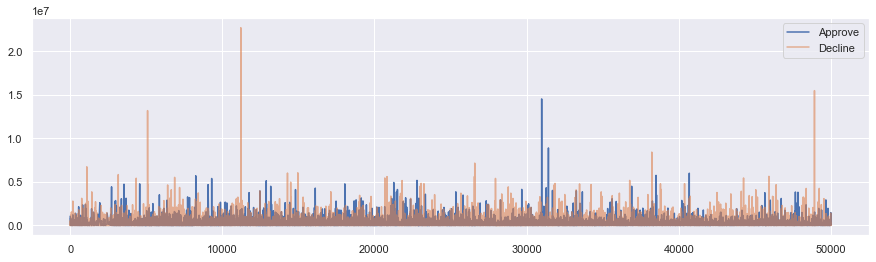

In [54]:
sns.set(rc={'figure.figsize':(15, 4)}) 
data.query('expert == 0').active_cred_sum.plot(label='Approve')
data.query('expert == 1').active_cred_sum.plot(alpha=0.6, label='Decline')
plt.legend()

<AxesSubplot:xlabel='expert', ylabel='active_cred_sum'>

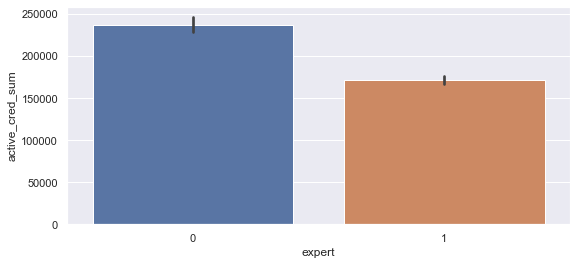

In [55]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.barplot(x='expert', y='active_cred_sum', data=data)

In [56]:
# Визуальный анализ: не показывает яркой взаимосвязи факторов, видно что чем больше сумма всех активных кредитов, тем с большей вероятностью одобрят заявку 

In [57]:
 pd.DataFrame({'-': data.query('expert == 1').active_cred_sum.describe().apply(lambda x: format(x, 'f')), 
               '+': data.query('expert == 0').active_cred_sum.describe().apply(lambda x: format(x, 'f'))})

,-,+
count,31714.000000,11229.000000
mean,171480.771628,237382.864460
std,408290.606916,464105.599374
min,0.000000,0.000000
25%,12400.000000,17000.000000
50%,47500.000000,84990.000000
75%,162624.720000,264490.000000
max,22731655.240000,14546128.700000


In [58]:
#Вывод: можно ничего не менять или сделать бинарную классифиикаю по квантилю 50 для одобренных заявок или проделать нормализацию значений, пока сделаем просто классификацию 
X['Binary_active_cred_sum'] = X['active_cred_sum'].apply(lambda x: 1 if x>10000 else 0)

In [59]:
#5.active_cred_day_overdue - суммарная просрочка в днях по всем актуальным кредитам
#Признак должен хорошо разделять выборку, ибо обычно чем больше сумма просрочки по уже имеющимся кредитам, тем с меньшим желанием организация будет давать кредит 

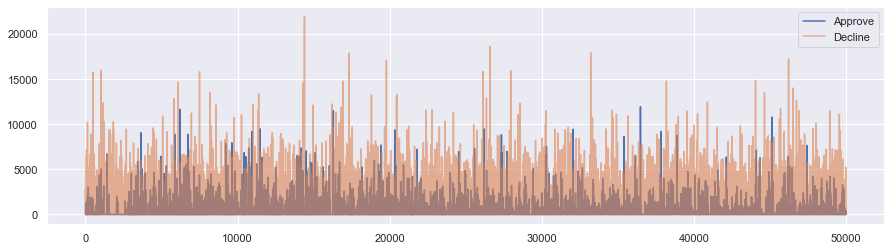

In [60]:
sns.set(rc={'figure.figsize':(15, 4)}) 
data.query('expert == 0').active_cred_day_overdue.plot(label='Approve')
data.query('expert == 1').active_cred_day_overdue.plot(alpha=0.6, label='Decline')
plt.legend()

<AxesSubplot:xlabel='expert', ylabel='active_cred_day_overdue'>

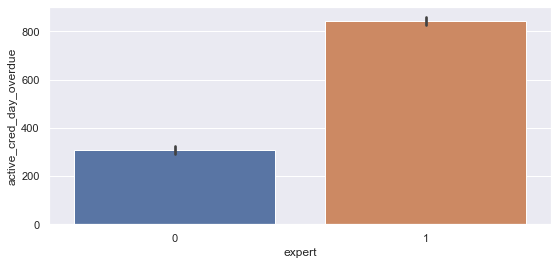

In [61]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.barplot(x='expert', y='active_cred_day_overdue', data=data)

In [62]:
# Визуальный анализ: достаточно наглядно можно видеть, что чем больше суммарная просрочка в днях по активным кредитам, тем с большей вероятностью отклонят заявку 

In [63]:
 pd.DataFrame({'-': data.query('expert == 1').active_cred_day_overdue.describe().apply(lambda x: format(x, 'f')), 
               '+': data.query('expert == 0').active_cred_day_overdue.describe().apply(lambda x: format(x, 'f'))})

,-,+
count,31714.000000,11229.000000
mean,843.313710,307.086294
std,1443.946811,872.587022
min,0.000000,0.000000
25%,0.000000,0.000000
50%,186.000000,0.000000
75%,1101.000000,71.000000
max,21927.000000,11936.000000


In [64]:
#вывод: создаём бинарный признак, где если если значение больше 71 то 1
X['Binary_active_cred_day_overdue'] = X['active_cred_day_overdue'].apply(lambda x: 1 if x>0 else 0)

In [65]:
#6.active_cred_max_overdue - максимальная сумма просроченной задолженности по активным кредитам 

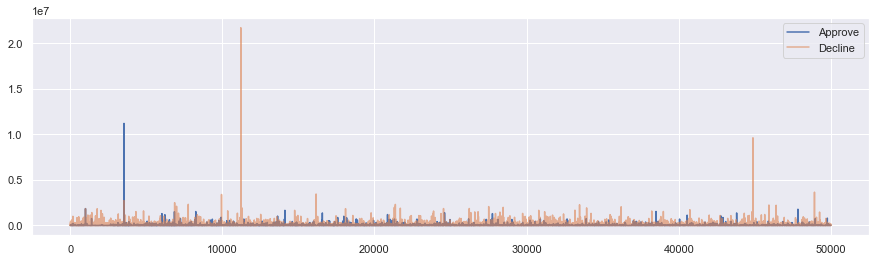

In [66]:
sns.set(rc={'figure.figsize':(15, 4)}) 
data.query('expert == 0').active_cred_max_overdue.plot(label='Approve')
data.query('expert == 1').active_cred_max_overdue.plot(alpha=0.6, label='Decline')
plt.legend()

<AxesSubplot:xlabel='expert', ylabel='active_cred_max_overdue'>

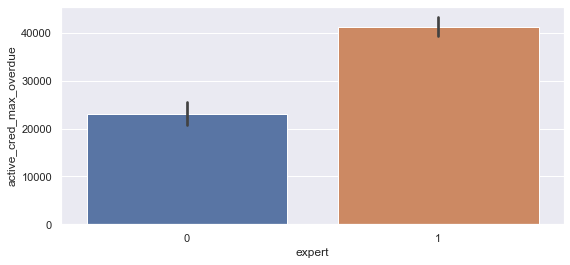

In [67]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.barplot(x='expert', y='active_cred_max_overdue', data=data)

In [68]:
# Визуальный анализ: картина достаточно сильно похожа на признак active_cred_sum_overdue, что поддтвердило найденную раннее корреляцию. 

In [69]:
 pd.DataFrame({'-': data.query('expert == 1').active_cred_max_overdue.describe().apply(lambda x: format(x, 'f')), 
               '+': data.query('expert == 0').active_cred_max_overdue.describe().apply(lambda x: format(x, 'f'))})

,-,+
count,31714.000000,11229.000000
mean,41215.358057,23004.493526
std,180110.676091,133815.454629
min,0.000000,0.000000
25%,1500.000000,0.000000
50%,9000.000000,2542.270000
75%,29165.475000,11700.000000
max,21701655.240000,11200890.000000


In [70]:
pd.DataFrame(pd.qcut(X['active_cred_max_overdue'], 3)).active_cred_max_overdue.unique()

[(-0.001, 2225.11], (15000.0, 21701655.24], (2225.11, 15000.0]]
Categories (3, interval[float64]): [(-0.001, 2225.11] < (2225.11, 15000.0] < (15000.0, 21701655.24]]

In [71]:
# Вывод: разделить данные на 3-4 категории. Границы приближая к данным квантилей распределения 
X['Categories_active_cred_max_overdue'] = pd.cut(X['active_cred_max_overdue'], bins=[0, 2225, 15000, 25000000], include_lowest=True, labels=['1','2','3']).astype(int);

In [72]:
#7Создадим несколько дополнительных признаков, которые могут дополнительно помочь в классификации 
# A. Есть ли у клиента погашенные кредиты и активные кредиты, то есть участвовал ли он вообще в кредитных отношениях 
#Если сумма данных значений будет равна нулю значит нет погашенных и активных кредитов, следовательно новый клиент 
X['New_Client'] =  (X.closed_cred_sum + X.active_cred_sum).apply(lambda x: 1 if x==0 else 0)

#Б. на сколько суммарная задолженность по активным кредитам больше чем сумма, которую клиент выплатил по закрытым кредитам. 
# Чем больше данное значение тем сложнее клиенту будет погасить задолженность, так как такой задолженность у него никогда не было. 
# Если значение положительно, то значит клиент уже сталкивался с такой задолженностью и оплачивал её, если нет, 
# то не закрывал кредиты на такие суммы и это риск давать новый кредит. 
X['New_Exp_in_Credit'] = (X.closed_cred_sum - X.active_cred_sum_overdue).apply(lambda x: 1 if x>0 else 0)

In [73]:
#Анализ перменных характеризующие клиента 

In [74]:
# 1. age - вероятнее всего, что чем старше клиент, тем меньше вероятность одобрения кредита 

<AxesSubplot:xlabel='expert', ylabel='age'>

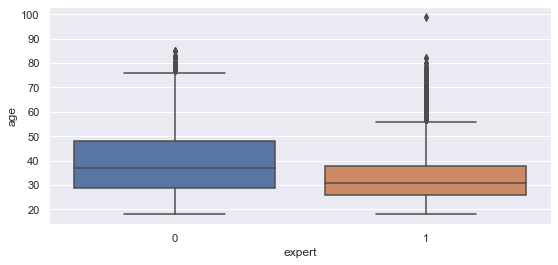

In [75]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.boxplot(x='expert', y='age', data=data)

In [76]:
# Визуальный анализ: возраст не является значимым фактором, потому как разделяет выборку по значению лейбла практически равнозначно 

In [77]:
 pd.DataFrame({'-': data.query('expert == 1').age.describe().apply(lambda x: format(x, 'f')), 
               '+': data.query('expert == 0').age.describe().apply(lambda x: format(x, 'f'))})

,-,+
count,31714.000000,11229.000000
mean,33.410292,39.531659
std,10.182259,13.064350
min,18.000000,18.000000
25%,26.000000,29.000000
50%,31.000000,37.000000
75%,38.000000,48.000000
max,99.000000,85.000000


In [78]:
# Вывод: можно сделать бинарный признак с отметкой больше модального возраста для тех кому не дали кредит, а лучше ничего с этим делать 
# X['Age_Threshold'] = X['age'].apply(lambda x: 1 if x<35 else 0)

In [79]:
# 2. gender 

<AxesSubplot:xlabel='expert', ylabel='gender'>

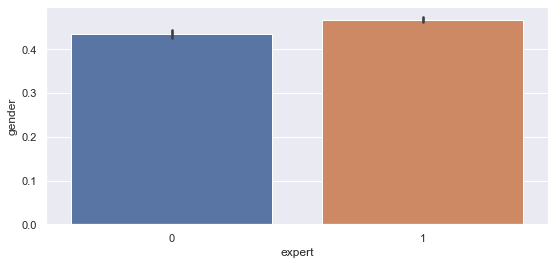

In [80]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.barplot(x='expert', y='gender', data=data)

In [81]:
# Вывод: статистика признака ничего не даёт, признак и так бинарен, еще и равно распределен по данным, можно вообще убрать
X = X.drop('gender', axis=1) 

In [82]:
#3. region 

In [83]:
data.query('expert == 1').region.value_counts().head(10), data.query('expert == 0').region.value_counts().head(10)

(0     11811
 40     2012
 36     1348
 75     1166
 65     1135
 52      938
 80      881
 3       790
 46      706
 45      630
 Name: region, dtype: int64,
 0     5794
 40    1656
 80     394
 75     358
 52     302
 41     254
 36     246
 65     185
 3      147
 45     132
 Name: region, dtype: int64)

In [84]:
#Вывод: регион не имеет особо значения, можно создать разряженную матрицу со значениями, можно выкинуть, 
# для первого варианта модели ничего менять тут не будем

In [85]:
#4. Доход 
# Здесь должно быть неплохое разделение, потому что как  правило чем больше человек зарабатывает темб ольше ему дадут, 
# также ранне был разработан признак включающий общую сумму заработка всех клиентов участвующих в заявке 


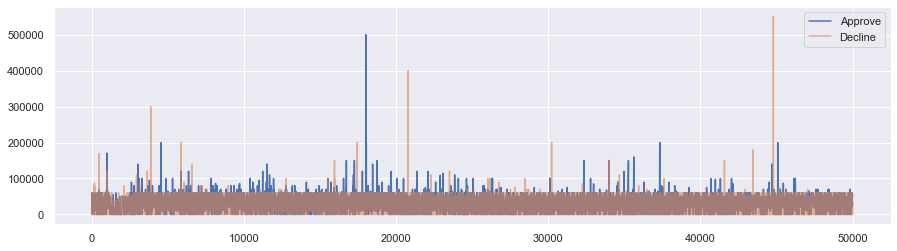

In [86]:
sns.set(rc={'figure.figsize':(15, 4)}) 
data.query('expert == 0').month_income.plot(label='Approve')
data.query('expert == 1').month_income.plot(alpha=0.6, label='Decline')
plt.legend()

<AxesSubplot:xlabel='expert', ylabel='month_income'>

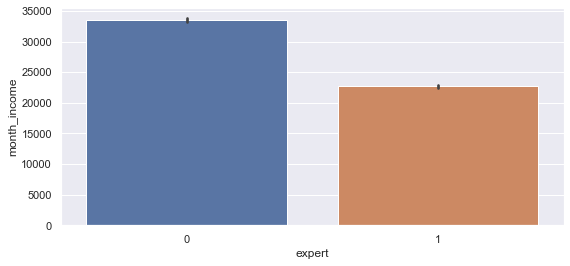

In [87]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.barplot(x='expert', y='month_income', data=data)

<AxesSubplot:xlabel='expert', ylabel='month_income'>

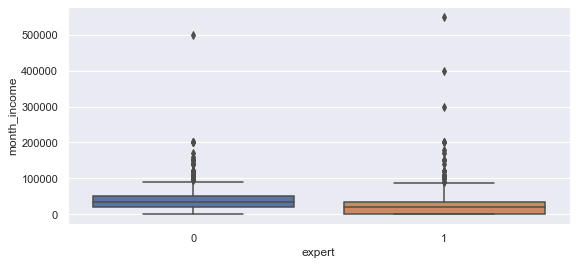

In [88]:
sns.boxplot(x='expert', y='month_income', data=data)

In [89]:
 pd.DataFrame({'-': data.query('expert == 1').month_income.describe().apply(lambda x: format(x, 'f')), 
               '+': data.query('expert == 0').month_income.describe().apply(lambda x: format(x, 'f'))})

,-,+
count,31714.000000,11229.000000
mean,22702.479315,33457.258126
std,20497.061865,18464.901509
min,0.000000,0.000000
25%,0.000000,21000.000000
50%,20000.000000,35000.000000
75%,35000.000000,50000.000000
max,550000.000000,500000.000000


In [90]:
# Вывод: предположение не оправдалось, по одному доходу достаточно сложно классифицировать успех заявки. Данные столбца либо убирать, либо нормализовать. Применим нормализацию:
X['Income_Threshold'] = X.month_income.apply(lambda x: 1 if x<23000 else 0 )


In [91]:
#Аналих признаков относящихся к переменным, характеризующим кредит, по которому нужно сделать прогноз 

In [92]:
# 1. first_loan - сумма, которую клиент хочет получить в кредит 
# Скорее всего само по себе значение никак не может помочь в связке 

<AxesSubplot:xlabel='expert', ylabel='first_loan'>

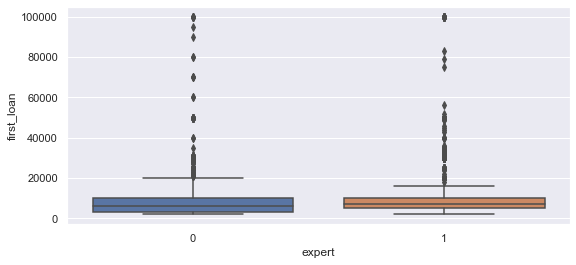

In [93]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.boxplot(x='expert', y='first_loan', data=data)

In [94]:
#максимальная запрошенная сумма равна 100000, значит анализ происходится либо для микрокредитной организации, либо из генеральной совокупности были убраны все сделки крупнее данной 
X.first_loan.sort_values(ascending=False)

29571    100000.0
5726     100000.0
7145     100000.0
32170    100000.0
3478     100000.0
           ...   
25827      2000.0
25821      2000.0
25794      2000.0
25760      2000.0
42942      2000.0
Name: first_loan, Length: 42943, dtype: float64

In [95]:
# Вывод: пока признак не используем

In [96]:
# 2. first_days_quant - срок на который клиент хочет взять кредит 

<AxesSubplot:xlabel='expert', ylabel='first_days_quant'>

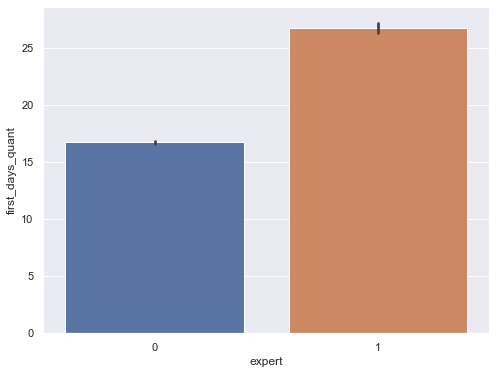

In [97]:
sns.set(rc={'figure.figsize':(8, 6)})
sns.barplot(x='expert', y='first_days_quant', data=data)

<AxesSubplot:xlabel='expert', ylabel='first_days_quant'>

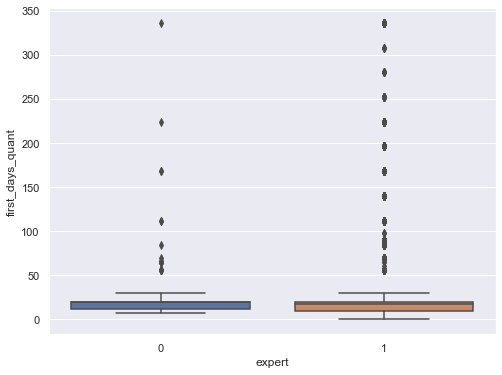

In [98]:
sns.set(rc={'figure.figsize':(8, 6)})
sns.boxplot(x='expert', y='first_days_quant', data=data)

In [99]:
 pd.DataFrame({'-': data.query('expert == 1').first_days_quant.describe().apply(lambda x: format(x, 'f')), 
               '+': data.query('expert == 0').first_days_quant.describe().apply(lambda x: format(x, 'f'))})

,-,+
count,31714.000000,11229.000000
mean,26.781138,16.756523
std,43.411828,7.151662
min,0.000000,7.000000
25%,10.000000,12.000000
50%,18.000000,20.000000
75%,20.000000,20.000000
max,336.000000,336.000000


In [100]:
# Вывод: признак на первый взгляд сам по себе бесполезен, имеет одинаковое распрделение среди обоих лейблов, 
# но можно использовать в признаке, которые определяет риск возникновения просрочки по новому кредиту. 
# Берется разница между суммарной просрочкой в днях для актуальных кредитов и данных показателем. 
# Если значение положительное, то риск просрочки выше, так как известно что такого кол-ва дней клиенту не достаточно на погашение. 
# Если число <=0, то риск просрочки меньше 

# Реально ли клиент сможет оплатить кредит в срок исходя из суммы которую он хочет и данных о зарплате. 
X['Ehough_Income_']=(X.first_loan - X.month_income* X.first_days_quant/30).apply(lambda x: 1 if x<=0 else 0 )

X['Risk_overdue_day'] = (X.active_cred_day_overdue - X.first_days_quant) 

In [101]:
X

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,region,first_loan,first_days_quant,...,binary_closed_creds,Binary_active_cred_sum_overdue,Binary_active_cred_sum,Binary_active_cred_day_overdue,Categories_active_cred_max_overdue,New_Client,New_Exp_in_Credit,Income_Threshold,Ehough_Income_,Risk_overdue_day
0,143822.00,22,104.12,130068.80,8,756.09,31,36,10000.0,196,...,1,1,1,1,1,0,1,1,0,-188
1,0.00,0,38151.93,46230.00,1492,38151.93,51,93,10000.0,17,...,0,1,1,1,3,0,0,1,1,1475
2,51356.00,2,3000.00,3000.00,8,3000.00,28,3,10000.0,84,...,0,1,0,1,2,0,1,1,0,-76
3,0.00,0,22784.19,32103.52,913,22784.19,28,52,10000.0,7,...,0,1,1,1,3,0,0,1,0,906
4,0.00,0,22784.19,32103.52,934,22784.19,29,0,10000.0,20,...,0,1,1,1,3,0,0,1,0,914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42938,0.00,0,26758.57,25000.00,371,26758.57,44,42,3000.0,23,...,0,1,1,1,3,0,0,0,1,348
42939,0.00,0,74662.61,79662.61,2593,42204.55,27,0,4000.0,20,...,0,1,1,1,3,0,0,1,0,2573
42940,21653.49,2,0.00,0.00,0,0.00,28,75,2000.0,10,...,0,0,0,0,1,0,1,1,1,-10
42941,0.00,0,0.00,1000.00,0,941.00,22,0,10000.0,20,...,0,0,0,0,1,0,0,0,1,-20


In [102]:
# 3. order_date - дата подачи заявки, врядл-ли может что-то говорить или влиять на результат. 
# Если только не рассчитываться сколько организация одобрила уже кредитов в определенный месяц, 
# так как у любой кредитной организации есть лимиты по выдаче. Оставим только месяц.
X.order_date = X.order_date.apply(lambda x: x[5:-3])

In [103]:
#4. по признакам с id в самом начале были выполнены действия + client id может показывать сколько клиент живёт в бизнесе-чем меньше id тем
#  раньше был заргеан у нас в базе клиент 

In [104]:
X = pd.get_dummies(X)

In [105]:
# Всего признаков:
X.columns

Index(['closed_cred_sum', 'closed_creds', 'active_cred_sum_overdue',
       'active_cred_sum', 'active_cred_day_overdue', 'active_cred_max_overdue',
       'age', 'region', 'first_loan', 'first_days_quant', 'month_income',
       'order_id', 'client_id', 'expert', 'count_of_order',
       'count_of_clients_in_order', 'sum_salary_of_members',
       'closed_cred_sum_Category', 'binary_closed_creds',
       'Binary_active_cred_sum_overdue', 'Binary_active_cred_sum',
       'Binary_active_cred_day_overdue', 'Categories_active_cred_max_overdue',
       'New_Client', 'New_Exp_in_Credit', 'Income_Threshold', 'Ehough_Income_',
       'Risk_overdue_day', 'order_date_06', 'order_date_07', 'order_date_08',
       'order_date_09'],
      dtype='object')

In [106]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42943 entries, 0 to 42942
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   closed_cred_sum                     42943 non-null  float64
 1   closed_creds                        42943 non-null  int64  
 2   active_cred_sum_overdue             42943 non-null  float64
 3   active_cred_sum                     42943 non-null  float64
 4   active_cred_day_overdue             42943 non-null  int64  
 5   active_cred_max_overdue             42943 non-null  float64
 6   age                                 42943 non-null  int64  
 7   region                              42943 non-null  int64  
 8   first_loan                          42943 non-null  float64
 9   first_days_quant                    42943 non-null  int64  
 10  month_income                        42943 non-null  float64
 11  order_id                            42943

In [107]:
#Отделим признаковую часть от лейблов 
y = X.expert
X = X.drop('expert', axis=1) 

In [108]:
#редактирование состовляющей X после кэтбуста

X = X[['closed_cred_sum', 'closed_creds', 'active_cred_sum_overdue',
       'active_cred_sum', 'active_cred_day_overdue', 'active_cred_max_overdue',
       'age', 'region', 'first_loan', 'first_days_quant', 'month_income',
       'order_id', 'client_id', 'count_of_order', 
       'sum_salary_of_members', 'closed_cred_sum_Category',
       'binary_closed_creds', 'Binary_active_cred_sum_overdue',
       'Binary_active_cred_sum', 'Binary_active_cred_day_overdue',
       'Categories_active_cred_max_overdue', 'New_Client', 'New_Exp_in_Credit', 
       'Ehough_Income_', 'Risk_overdue_day']]

In [109]:
#Деление датасета на обучающую часть и тестовую 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [110]:
#Обучение catboost 
Cat = CatBoostClassifier(verbose=50,
                           random_state=42,
                           learning_rate=0.1, #увеличение скорости обучени (чтобы последняя итерация была ближе к концу, а не ближе к началу)
                           early_stopping_rounds=200, #если 200 итераций нет улучшений, то алгоритм перестает работать
                           eval_metric='AUC'
                           )

In [111]:
Cat.fit(X_train, y_train,
          eval_set=(X_test, y_test))

0:	test: 0.8772829	best: 0.8772829 (0)	total: 248ms	remaining: 4m 8s
50:	test: 0.9378462	best: 0.9378462 (50)	total: 847ms	remaining: 15.8s
100:	test: 0.9438030	best: 0.9438030 (100)	total: 1.49s	remaining: 13.3s
150:	test: 0.9474865	best: 0.9474865 (150)	total: 2.14s	remaining: 12.1s
200:	test: 0.9492432	best: 0.9492542 (199)	total: 2.74s	remaining: 10.9s
250:	test: 0.9500965	best: 0.9501212 (249)	total: 3.3s	remaining: 9.84s
300:	test: 0.9504193	best: 0.9504568 (296)	total: 3.9s	remaining: 9.07s
350:	test: 0.9510012	best: 0.9510012 (350)	total: 4.46s	remaining: 8.25s
400:	test: 0.9512859	best: 0.9513408 (385)	total: 5.02s	remaining: 7.5s
450:	test: 0.9514997	best: 0.9515372 (443)	total: 5.65s	remaining: 6.88s
500:	test: 0.9514518	best: 0.9515372 (443)	total: 6.2s	remaining: 6.17s
550:	test: 0.9515608	best: 0.9516245 (545)	total: 6.8s	remaining: 5.54s
600:	test: 0.9515588	best: 0.9516268 (587)	total: 7.38s	remaining: 4.9s
650:	test: 0.9513928	best: 0.9516268 (587)	total: 7.94s	remaini

In [112]:
fi = pd.DataFrame({'w':Cat.feature_importances_,'name':X_train.columns})

In [113]:
fi.sort_values(by='w', ascending=False) #удаляем полность order_date, incime_threshold, count_of_clients_in_order

,w,name
9,17.505185,first_days_quant
12,10.941630,client_id
10,7.777113,month_income
8,6.397227,first_loan
2,6.289456,active_cred_sum_overdue
14,5.688263,sum_salary_of_members
1,5.195390,closed_creds
6,4.851346,age
7,4.572533,region
4,4.433340,active_cred_day_overdue


In [114]:
y_pred_score = Cat.predict_proba(X_test)[:,1]

In [115]:
#Получим границу вероятности от кривой auc

In [116]:
fpr, tpr, thr = roc_curve(y_test, y_pred_score)
roc = pd.DataFrame({'fpr':fpr,'tpr':tpr,'thr':thr})

<AxesSubplot:xlabel='fpr'>

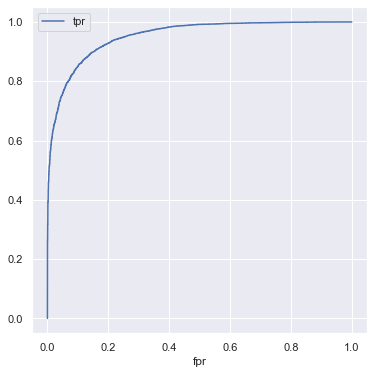

In [117]:
roc.plot(x='fpr',y='tpr',figsize=(6,6),grid=True)

In [118]:
roc['tpr-fpr'] = roc['tpr'] - roc['fpr'] #назодим ту границу, где комбинация tpr и fpr даёт наилучший результат

In [121]:
roc.sort_values('tpr-fpr',ascending=False)

,fpr,tpr,thr,tpr-fpr
688,0.118860,0.872822,0.753885,0.753962
686,0.118557,0.872509,0.754536,0.753952
684,0.117950,0.871883,0.755627,0.753933
692,0.119770,0.873657,0.751737,0.753887
694,0.120073,0.873865,0.751298,0.753793
...,...,...,...,...
1919,0.944209,1.000000,0.003562,0.055791
1918,0.944209,0.999896,0.003601,0.055687
1,0.000000,0.000104,0.999981,0.000104
0,0.000000,0.000000,1.999981,0.000000


In [119]:
best_thr = roc.sort_values('tpr-fpr',ascending=False)['thr'].iloc[0]
best_thr

0.7538851466999943

In [194]:
y_pred = (y_pred_score >= best_thr)*1

In [195]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78      3298
           1       0.96      0.87      0.91      9585

    accuracy                           0.87     12883
   macro avg       0.83      0.88      0.85     12883
weighted avg       0.89      0.87      0.88     12883



array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

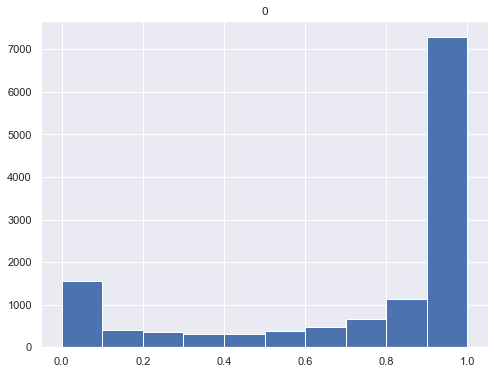

In [200]:
pd.DataFrame(y_pred_score).hist()

In [ ]:
# Использование других моделей:

In [165]:
#Тестирование различных моделей 
# 1. Лес
rf1 = RandomForestClassifier()
parameters = {'criterion': ['gini'],
             'n_estimators' : range(60, 100, 10),
             'max_depth': range(8 ,30, 2),
             'min_samples_split': range(10, 30, 2),
             'min_samples_leaf': range(5, 10)
             }
rsrf = RandomizedSearchCV(rf1, parameters, n_jobs=-1)

# 2. 
xgb1 = XGBClassifier(objective="binary:logistic", random_state=42)

# 3
sgd1 = SGDClassifier(loss='log', random_state=17, n_jobs=-1, alpha=5e-06, max_iter=500)

# 4
Logistic1 = LogisticRegression(C=1, random_state=17, solver='lbfgs', n_jobs=-1, class_weight='balanced')

In [166]:
#Создание общей функции для одновременного теста нескольких моделей сразу с подсчётом метрик качества 

In [167]:
def Modelauc (model1, model2, model3, model4, X_train, X_test, y_train, y_test):
    pok = [] #список для вероятностей 
    pak=[] #список для бинарных значений
    model_list = [model1, model2, model3, model4]
    # model_list = [model1, model2] 
    for model in model_list:
        model.fit(X_train, y_train);
       
        a = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]);
        b = precision_score(y_test, model.predict(X_test));
        c = recall_score(y_test, model.predict(X_test));
        d = accuracy_score(y_test, model.predict(X_test));
        e = f1_score(y_test, model.predict(X_test));

        pok.append(model.predict_proba(X_test)[:, 1]);
        pak.append(model.predict(X_test))

        print('For model', str(model)[0:11], 'ROC_AUC=', a)
        print('For model', str(model)[0:11], 'Prec=', b)
        print('For model', str(model)[0:11], 'Recall=', c)
        print('For model', str(model)[0:11], 'Accuracy_score=', d)
        print('For model', str(model)[0:11], 'F1_score=', e)
        print('____________________________________________________')

      # return(pok)


In [168]:
Modelauc(rsrf, xgb1, sgd1, Logistic1, X_train, X_test, y_train, y_test)

For model RandomizedS ROC_AUC= 0.93930604944493
For model RandomizedS Prec= 0.901821060965954
For model RandomizedS Recall= 0.9506520605112154
For model RandomizedS Accuracy_score= 0.8862842505627572
For model RandomizedS F1_score= 0.9255929706942962
____________________________________________________
[03:13:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For model XGBClassifi ROC_AUC= 0.9483995453528846
For model XGBClassifi Prec= 0.9143949300875164
For model XGBClassifi Recall= 0.9483568075117371
For model XGBClassifi Accuracy_score= 0.895521229527284
For model XGBClassifi F1_score= 0.9310662706135409
____________________________________________________
For model SGDClassifi ROC_AUC= 0.5757770236177978
For model SGDClassifi Prec= 0.7785097893662429
For model SGDClassifi Recall= 0.8753260302556077
For model SGDClassifi Accuracy_score= 0.7219591710005433
For model SGDClassifi F1_score= 0.8240840781848542
____________________________________________________
For model LogisticReg ROC_AUC= 0.7904917002859417
For model LogisticReg Prec= 0.8726990198422185
For model LogisticReg Recall= 0.7617110067814293
For model LogisticReg Accuracy_score= 0.7400450205697431
For model LogisticReg F1_score= 0.8134365773494514
____________________________________________________
